`Task Formulation`<br>
Implement functionality to classify text comments as positive, neutral or negative.

# Data overview
`Data Quality`<br>
Careful review of `Data Card` and `Data Explorer` associated with `transactional_data.sqlite` reveals two minor issues with this data:
* `orders.timestamp` is VARCHAR
* Couple of missing values for `products.product_weight_g`<br>

`SQL Alchemy`<br>
SQLAlchemy is a Python library that allows you to leverage DBMS efficiency and interact with databases conveniently from within your notebook. It supports multiple Database Management Systems (DBMSs), including SQLite, PostgreSQL, MySQL, and Oracle.

In [1]:
from sqlalchemy import create_engine, inspect, text

# Create a database engine
engine = create_engine('sqlite:////home/petewojtczak/databases/transactional_data.sqlite')

# simplified schema and tables info
with engine.connect() as conn:
    inspector = inspect(engine)    
    for table_name in inspector.get_table_names():
        # Retrieve column information
        columns_info = inspector.get_columns(table_name)
        columns = [col['name'] for col in columns_info]        
        # Check for primary key
        primary_key = next((col['name'] for col in columns_info if col['primary_key']), None)        
        # Check for foreign keys
        foreign_keys_info = inspector.get_foreign_keys(table_name)
        foreign_key_columns = [fk['constrained_columns'][0] for fk in foreign_keys_info]        
        # Count the number of records in the table
        num_records_query = text(f"SELECT COUNT(*) FROM '{table_name}'")
        num_records = conn.execute(num_records_query).scalar()        
        # Print results
        print(f"\n\033[1m'{table_name}'\033[0m")
        print(f"Number of Records: {num_records}")
        print(f"Columns: {columns}")
        print(f"Primary Key: {primary_key}")
        if foreign_key_columns:
            print("Foreign Key Column(s):")
            for fk_column in foreign_key_columns:
                print(f"  - {fk_column}")
        else:
            print("Foreign Key: None")


'order_items'
Number of Records: 110197
Columns: ['order_items_pk', 'order_id', 'product_id', 'seller_id', 'price']
Primary Key: order_items_pk
Foreign Key Column(s):
  - order_id
  - product_id
  - seller_id

'order_reviews'
Number of Records: 39462
Columns: ['review_id', 'order_id', 'review_score', 'review_comment_message']
Primary Key: review_id
Foreign Key Column(s):
  - order_id

'orders'
Number of Records: 96478
Columns: ['order_id', 'timestamp', 'customer_contact']
Primary Key: order_id
Foreign Key: None

'products'
Number of Records: 32216
Columns: ['product_id', 'product_category_name', 'product_weight_g']
Primary Key: product_id
Foreign Key: None

'sellers'
Number of Records: 2970
Columns: ['seller_id', 'seller_state']
Primary Key: seller_id
Foreign Key: None


`order_reviews`<br>
Includes text reviews and star rating associated with each order.<br>
**Columns description**:
* `review_id`; PK, unique review identifier(VARCHAR).<br>
* `order_id`; FK, order unique identifier(VARCHAR).<br>
* `review_score`; note ranging from 1 to 5 given by the customer on a satisfaction survey(INTEGER).<br>
* `review_comment_message`; comment message from the review left by the customer, in Portuguese (VARCHAR).<br>

In [2]:
import pandas as pd
import numpy as n

query = """
SELECT 
    review_id, 
    order_id, 
    review_score, 
    review_comment_message 
FROM 
    order_reviews
"""
order_reviews = pd.read_sql_query(query, engine)
order_reviews.head(3)

,review_id,order_id,review_score,review_comment_message
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...


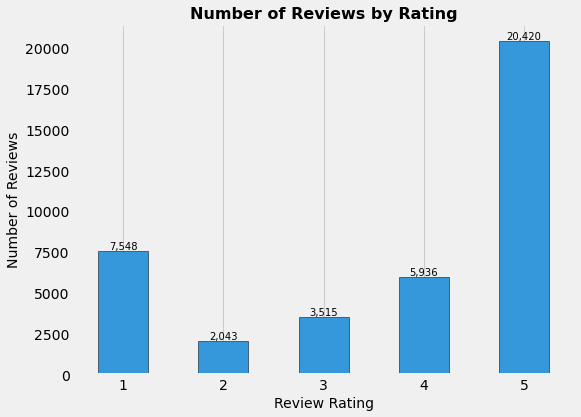

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 6))
order_reviews.review_score.value_counts().sort_index().plot(
    kind='bar', 
    color='#3498db', 
    edgecolor='black', 
    ax=ax
)
# Set titles and labels
ax.set_title('Number of Reviews by Rating', fontsize=16, weight='bold')
ax.set_xlabel('Review Rating', fontsize=14)
ax.set_ylabel('Number of Reviews', fontsize=14)
# Rotate x-tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
# Add gridlines for y-axis only
ax.grid(axis='y', linestyle='--', alpha=0.7)
# Display values on top of each bar
for p in ax.patches:
    ax.annotate(
        format(int(p.get_height()), ','), 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', 
        va='center', 
        xytext=(0, 5), 
        textcoords='offset points',
        fontsize=10
    )
plt.show()

# RoBERTa Model 
Base model is BERTabaporu, a RoBERTa model trained on Portuguese tweets. Fameous transformer architecture.<br> 135M parameters, fine-tuned specifically for our task. <br>https://huggingface.co/pysentimiento/bertweet-pt-sentiment

In [4]:
%%time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pysentimiento import create_analyzer

analyzer = create_analyzer(task="sentiment", lang="pt")

sentiments = []
pos_probs = []
neu_probs = []
neg_probs = []

for _, row in order_reviews.iterrows():
    output = analyzer.predict(row.review_comment_message)
    sentiments.append(output.output)
    pos_probs.append(output.probas['POS'])
    neu_probs.append(output.probas['NEU'])
    neg_probs.append(output.probas['NEG'])

order_reviews['sentiment'] = sentiments
order_reviews['POS'] = pos_probs
order_reviews['NEU'] = neu_probs
order_reviews['NEG'] = neg_probs

CPU times: user 2h 31min 24s, sys: 1min 3s, total: 2h 32min 27s
Wall time: 28min 1s


In [5]:
order_reviews

,review_id,order_id,review_score,review_comment_message,sentiment,POS,NEU,NEG
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,NEU,0.083059,0.865634,0.051306
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,POS,0.989135,0.008621,0.002244
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,NEG,0.040093,0.322280,0.637627
3,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",NEG,0.030705,0.360272,0.609023
4,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,"Vendedor confiável, produto ok e entrega antes...",NEU,0.108078,0.840541,0.051380
...,...,...,...,...,...,...,...,...
39457,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,Entregou dentro do prazo. O produto chegou em ...,POS,0.981024,0.015778,0.003198
39458,a709d176f59bc3af77f4149c96bae357,d5cb12269711bd1eaf7eed8fd32a7c95,3,"O produto não foi enviado com NF, não existe v...",NEU,0.045340,0.837953,0.116706
39459,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,"Excelente mochila, entrega super rápida. Super...",POS,0.990349,0.007916,0.001735
39460,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,1,Solicitei a compra de uma capa de retrovisor c...,NEG,0.003696,0.032343,0.963961


# Correlation (text comments vs review_score)

`Visual outlook`

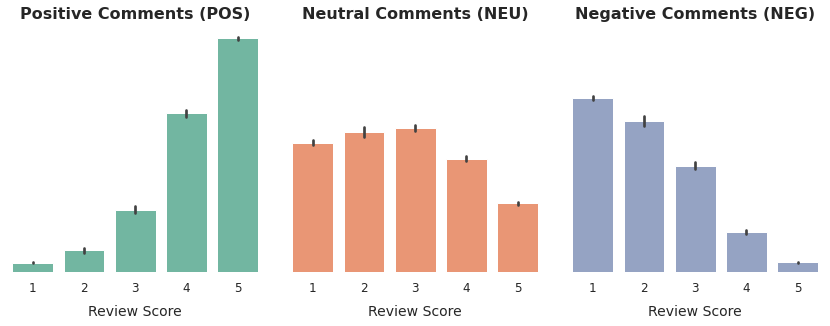

In [6]:
import seaborn as sns
sns.set(style="whitegrid")

# Creating the figure and subplots with shared y-axis
fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# Plotting each sentiment category 
sns.barplot(data=order_reviews, x='review_score', y='POS', ax=axs[0], color=colors[0])
sns.barplot(data=order_reviews, x='review_score', y='NEU', ax=axs[1], color=colors[1])
sns.barplot(data=order_reviews, x='review_score', y='NEG', ax=axs[2], color=colors[2])

# Setting titles and labels
titles = ['Positive Comments (POS)', 'Neutral Comments (NEU)', 'Negative Comments (NEG)']
for ax, title in zip(axs, titles):
    ax.set_title(title, fontsize=16, weight='bold')
    ax.set_xlabel('Review Score', fontsize=14, labelpad=10)
    ax.set_ylabel('')

axs[0].tick_params(axis='y', labelsize=12)

for ax in axs:
    ax.tick_params(axis='x', labelsize=12)
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set(yticks=[])

plt.tight_layout(pad=2.0)
plt.show()

`Spearman's rho (corr coeff)`<br>
Appropriate for two ordinal variables.

In [7]:
from scipy.stats import spearmanr

sentiment_mapping = {'NEG': -1, 'NEU': 0, 'POS': 1}
order_reviews['text_rating'] = order_reviews['sentiment'].map(sentiment_mapping)

rho, p_value = spearmanr(order_reviews['text_rating'], order_reviews['review_score'])

print("Spearman's rho:", rho)
print("p-value:", p_value)

Spearman's rho: 0.6773645765197137
p-value: 0.0


# Database Updates

In [8]:
%%time
# Check the existing columns in the order_reviews table
existing_columns = [column['name'] for column in inspector.get_columns('order_reviews')]

# Step 2: Check and add new columns if they don't exist
if 'sentiment' not in existing_columns:
    alter_table_query = """
        ALTER TABLE order_reviews 
        ADD COLUMN sentiment TEXT;
    """
    with engine.connect() as conn:
        conn.execute(alter_table_query)
        
if 'text_rating' not in existing_columns:
    alter_table_query = """
        ALTER TABLE order_reviews 
        ADD COLUMN text_rating INTEGER;
    """
    with engine.connect() as conn:
        conn.execute(alter_table_query)

# Step 3: Create a temporary DataFrame with only the columns to update
temp_df = order_reviews[['review_id', 'sentiment', 'text_rating']]

# Step 4: Create a temporary table in the database to hold the new values
temp_df.to_sql('temp_order_reviews', engine, if_exists='replace', index=False)

# Step 5: Update the original table from the temporary table using SQL
update_query = """
    UPDATE order_reviews 
    SET sentiment = (
        SELECT sentiment FROM temp_order_reviews
        WHERE temp_order_reviews.review_id = order_reviews.review_id
    ),
    text_rating = (
        SELECT text_rating FROM temp_order_reviews
        WHERE temp_order_reviews.review_id = order_reviews.review_id
    )
    WHERE review_id IN (SELECT review_id FROM temp_order_reviews);
"""

with engine.connect() as conn:
    conn.execute(update_query)

# Step 6: Drop the temporary table after updating
drop_temp_table_query = "DROP TABLE IF EXISTS temp_order_reviews;"
with engine.connect() as conn:
    conn.execute(drop_temp_table_query)

print("Database successfully updated with new columns.")

Database successfully updated with new columns.
CPU times: user 1min 15s, sys: 11.2 s, total: 1min 26s
Wall time: 1min 26s


# Key Findings
* Most endorsed products,
* Most endorsed sellers.

`Most endorsed products`

In [9]:
query = """
SELECT 
    p.product_id,
    p.product_category_name,
    AVG(rr.text_rating) AS avg_text_rating,
    AVG(rr.review_score) AS avg_review_score
FROM 
    products p
JOIN 
    order_items oi ON p.product_id = oi.product_id
JOIN 
    order_reviews rr ON oi.order_id = rr.order_id
GROUP BY 
    p.product_id, p.product_category_name
HAVING 
    COUNT(rr.text_rating) >= 15
ORDER BY 
    avg_text_rating DESC
"""
pd.read_sql_query(query, engine).head(10)

,product_id,product_category_name,avg_text_rating,avg_review_score
0,f8b624d4e475bb8d1bddf1b65c6a64f6,utilidades_domesticas,1.000000,5.000000
1,41c24b8ce92d1a2cac62db5edfd088b2,relogios_presentes,0.909091,4.545455
2,1491a8ff192d4b5c369b0eaa2fe33ee5,cama_mesa_banho,0.875000,4.375000
3,1ec486885049bbb9b79351d150ed18c4,fashion_bolsas_e_acessorios,0.875000,4.500000
4,fe01b643060a6446e59f58e3021e66b3,perfumaria,0.842105,4.631579
5,23bcd6822a33df5534f9b290216eec1f,brinquedos,0.823529,4.705882
6,aa280035c50ba62c746480a59045eec4,brinquedos,0.800000,4.850000
7,fc1d8637c0268af3db482c14b7ef8e75,cama_mesa_banho,0.772727,4.181818
8,7340a3839a1de1e99d149b8cf052a2ec,cama_mesa_banho,0.750000,4.312500
9,af51d485dc5255ba2e18b21b550156e6,malas_acessorios,0.733333,4.533333


`Most endorsed sellers`

In [10]:
query = """
SELECT 
    s.seller_id,
    s.seller_state,
    AVG(rr.text_rating) AS avg_text_rating,
    AVG(rr.review_score) AS avg_review_score
FROM 
    sellers s
JOIN 
    order_items oi ON s.seller_id = oi.seller_id
JOIN 
    order_reviews rr ON oi.order_id = rr.order_id
GROUP BY 
    s.seller_id, s.seller_state
HAVING 
    COUNT(rr.text_rating) >= 15
ORDER BY 
    avg_text_rating DESC
"""
pd.read_sql_query(query, engine).head(10)

,seller_id,seller_state,avg_text_rating,avg_review_score
0,48efc9d94a9834137efd9ea76b065a38,PR,0.962963,5.000000
1,b410bdd36d5db7a65dcd42b7ead933b8,GO,0.875000,4.875000
2,376a891762bbdecbc02b4b6adec3fdda,GO,0.857143,4.761905
3,744dac408745240a2c2528fb1b6028f3,PR,0.846154,4.615385
4,31561f325664a8a7aba4c8d0c3a9b3db,SP,0.812500,4.437500
5,080199a181c46c657dc5aa235411be3b,SP,0.800000,4.466667
6,bf3c6d2a28b2b5501e6c15448982dcc9,SP,0.800000,4.066667
7,2dee2ce60de9709b1a24083217181a1f,MT,0.782609,4.652174
8,a5cba26a62b8b4d0145b68b841e62e7f,PR,0.774194,4.612903
9,d921b68bf747894be13a97ae52b0f386,MG,0.774194,4.451613
